# Multi-Variate Pattern Analysis (MVPA)
## Computational Methods in Psychology and Neuroscience
### Psychology 4215/7215 --- Fall 2023
By: Per B. Sederberg, PhD



# Lesson Objectives

Upon completion of this lesson, students should have learned:

1. A quick fMRI primer
2. A dash through MRI preprocessing
3. Standard first-level GLM analysis
4. Multivariate pattern analysis


# Quick fMRI primer

![Arthurs & Boniface (2002)](http://2.bp.blogspot.com/-9q2tbD_ZcqE/VVcQZuAoVHI/AAAAAAAAFfo/AceWNBdSTm8/s1600/Fig2.png)
(From Arthurs & Boniface, 2002, *Trends in Neurosciences*)

## The slow hemodynamic response

![HRF](https://www.researchgate.net/profile/Markus-Barth-2/publication/224906750/figure/fig1/AS:393859306672150@1470914784606/Schematic-of-the-BOLD-hemodynamic-response-to-a-brief-stimulus-at-time-zero-After-the.png)

(From Barth and Poser, 2011)


## No neuroimaging modality is perfect...

... Trading off spatial and temporal resolution.

![Neuroimaging Modalities](http://2.bp.blogspot.com/-etqPHV_xz9s/VVZdaFj0WLI/AAAAAAAAFfQ/i_3DrkZ0wrY/s1600/fig6.jpg)

(From Sejnowski, Churchland and Movshon, 2014, *Nature Neuroscience*)

# NiLearn for Neuroimaing in Python

![](https://nilearn.github.io/dev/_static/nilearn-transparent.png)

You're going to need some new libraries for processing neuroimaging data:

```bash
conda install -c conda-forge nilearn
```


In [2]:
# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats
import os

# import nilearn stuff
from nilearn import plotting, image

# Data from OpenNeuro

A free and open platform for validating and sharing BIDS-compliant MRI, PET, MEG, EEG, and iEEG data.

## Flanker task (event-related)

https://openneuro.org/datasets/ds000102/versions/00001

## fMRIPrep: A Robust Preprocessing Pipeline for fMRI Data

![](https://raw.githubusercontent.com/oesteban/fmriprep/38a63e9504ab67812b63813c5fe9af882109408e/docs/_static/fmriprep-workflow-all.png)

## fMRI data are HUGE!

If you'd like to download the preprocessed data to follow along, use this link:

https://virginia.box.com/s/79uda2ueln81wccy3dnxnxiz2paxywq0

Note that this is 345MB once unzipped!

## Verify some of the preprocessing

In [3]:
# load the grey matter segmented image
gm_img = image.load_img('fmriprep/sub-07/anat/sub-07_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz')
gm_img.shape

(193, 229, 193)

In [4]:
193*229*193

8530021

In [5]:
# load a run and check the shape
run2 = image.load_img('fmriprep/sub-07/func/sub-07_task-flanker_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
run2.shape

(65, 77, 49, 146)

In [6]:
np.prod(run2.shape[:-1])

245245

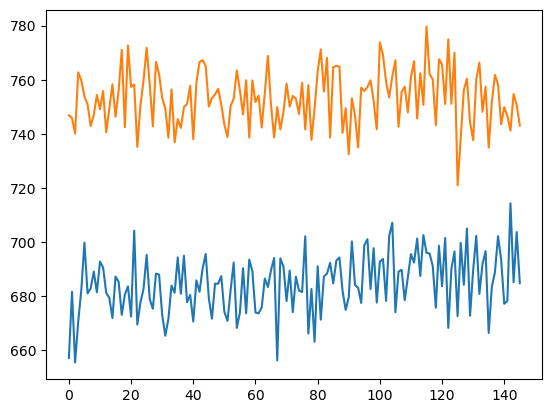

In [8]:
plt.plot(run2.get_fdata()[35, 35, 28, :])
plt.plot(run2.get_fdata()[45, 25, 32, :])

/home/per/anaconda3/envs/smiledev/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



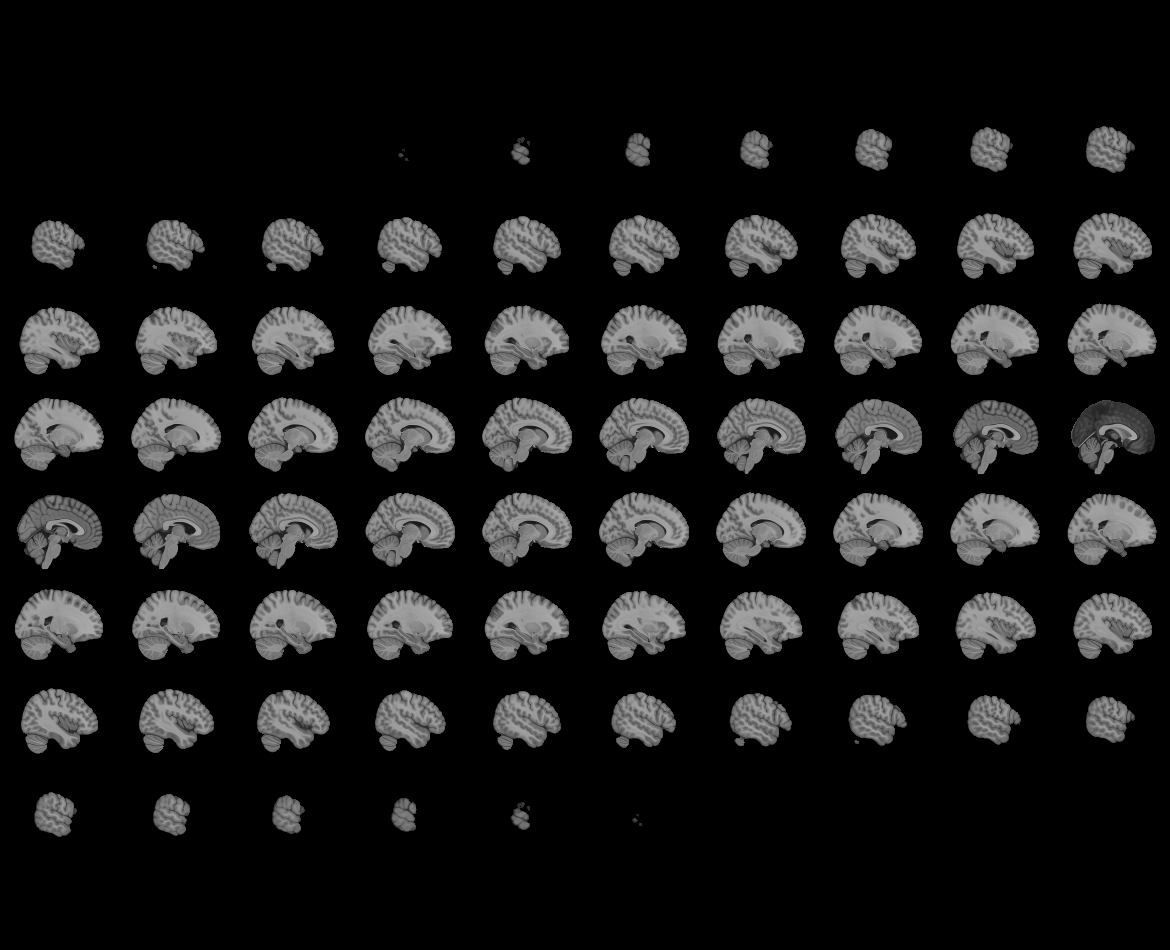
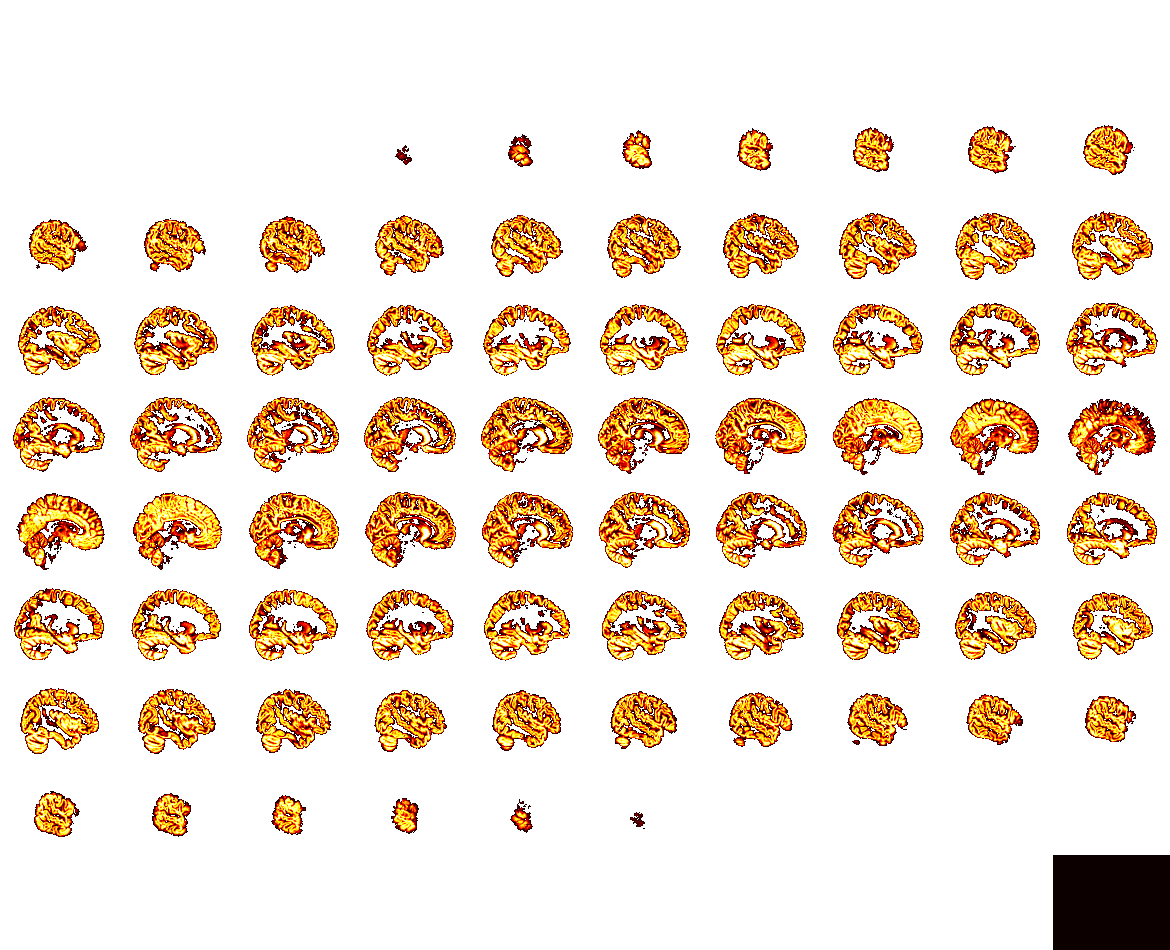

In [9]:
plotting.view_img(gm_img, symmetric_cmap=True,)

## Verify the behavioral data

In [10]:
# read in the behavioral data
df_1 = pd.read_table('fmriprep/sub-07/func/sub-07_task-flanker_run-1_events.tsv')
df_1['run'] = 1

df_2 = pd.read_table('fmriprep/sub-07/func/sub-07_task-flanker_run-2_events.tsv')
df_2['run'] = 2

df = pd.concat([df_1, df_2])

# fix the stim
df['Stimulus'] = [x.split('_')[0] for x in df['trial_type']]

# add log rt
df['log_rt'] = np.log(df['response_time'])
df.head()

,onset,duration,trial_type,response_time,correctness,StimVar,Rsponse,Stimulus,cond,run,log_rt
0,0.0,2.0,incongruent_correct,0.584,correct,2,1,incongruent,cond003,1,-0.537854
1,10.0,2.0,congruent_correct,0.492,correct,1,1,congruent,cond001,1,-0.709277
2,20.0,2.0,congruent_correct,0.408,correct,1,1,congruent,cond001,1,-0.896488
3,30.0,2.0,congruent_correct,0.347,correct,1,1,congruent,cond001,1,-1.058430
4,42.0,2.0,incongruent_correct,0.502,correct,2,1,incongruent,cond003,1,-0.689155


In [11]:
# test if they are slower on incongruent trials
stats.ttest_ind(df.loc[df['Stimulus']=='congruent', 'log_rt'],
                df.loc[df['Stimulus']=='incongruent', 'log_rt'])

TtestResult(statistic=-6.857497566052861, pvalue=1.491034532007445e-08, df=46.0)

- We see a significant slowdown for incongruent trials relative to congruent.

# First level Generalized Linear Model (GLM)

***Question: Is there any different in neural activity between congruent and incongruent conditions.***

## Generating a Design Matrix

- First step is to set up the independent variables.
- This will include the conditions, but also confounds to account for in the neural data.

In [12]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.plotting import plot_design_matrix

In [13]:
# read in the confounds
df_conf = pd.read_table('fmriprep/sub-07/func/sub-07_task-flanker_run-1_desc-confounds_timeseries.tsv')

# keep the most relevant
to_keep = ['csf',
'white_matter',
'tcompcor',
'std_dvars',
'dvars',
'framewise_displacement',
'rmsd',
't_comp_cor_00',
't_comp_cor_01',
't_comp_cor_02',
't_comp_cor_03',
't_comp_cor_04',
't_comp_cor_05',
'cosine00',
'cosine01',
'cosine02',
'non_steady_state_outlier00',
'non_steady_state_outlier01',
'trans_x',
'trans_x_derivative1',
'trans_x_power2',
'trans_x_derivative1_power2',
'trans_y',
'trans_y_derivative1',
'trans_y_derivative1_power2',
'trans_y_power2',
'trans_z',
'trans_z_derivative1',
'trans_z_power2',
'trans_z_derivative1_power2',
'rot_x',
'rot_x_derivative1',
'rot_x_derivative1_power2',
'rot_x_power2',
'rot_y',
'rot_y_derivative1',
'rot_y_power2',
'rot_y_derivative1_power2',
'rot_z',
'rot_z_derivative1',
'rot_z_derivative1_power2',
'rot_z_power2']
df_conf = df_conf[df_conf.columns[df_conf.columns.isin(to_keep)]]
df_conf = df_conf.dropna(axis=1)
df_conf.columns

Index(['csf', 'white_matter', 'tcompcor', 't_comp_cor_00', 't_comp_cor_01',
       't_comp_cor_02', 't_comp_cor_03', 't_comp_cor_04', 't_comp_cor_05',
       'cosine00', 'cosine01', 'cosine02', 'non_steady_state_outlier00',
       'non_steady_state_outlier01', 'trans_x', 'trans_x_power2', 'trans_y',
       'trans_y_power2', 'trans_z', 'trans_z_power2', 'rot_x', 'rot_x_power2',
       'rot_y', 'rot_y_power2', 'rot_z', 'rot_z_power2'],
      dtype='object')

In [14]:
# pull events and define onsets and durations
tr = 2.0  # repetition time is 2 second
n_scans = 146  # the acquisition comprises 128 scans
frame_times = np.arange(n_scans) * tr

events = pd.DataFrame({#'trial_type': ['ev'+str(x).zfill(2) for x in df[df['run']==1].index],
                       'trial_type': df[df['run']==1]['Stimulus'],
                       'onset': df[df['run']==1]['onset'],
                       'duration': df[df['run']==1]['duration']})
events

,trial_type,onset,duration
0,incongruent,0.0,2.0
1,congruent,10.0,2.0
2,congruent,20.0,2.0
3,congruent,30.0,2.0
4,incongruent,42.0,2.0
5,congruent,52.0,2.0
6,incongruent,64.0,2.0
7,incongruent,76.0,2.0
8,incongruent,88.0,2.0
9,congruent,102.0,2.0


In [15]:
# build the design matrix
hrf_model = 'glover'
X1 = make_first_level_design_matrix(
    frame_times, events, drift_model='polynomial', drift_order=3,
    add_regs=df_conf.to_numpy(), 
    add_reg_names=list(df_conf.columns), hrf_model=hrf_model)

<Axes: label='conditions', ylabel='scan number'>

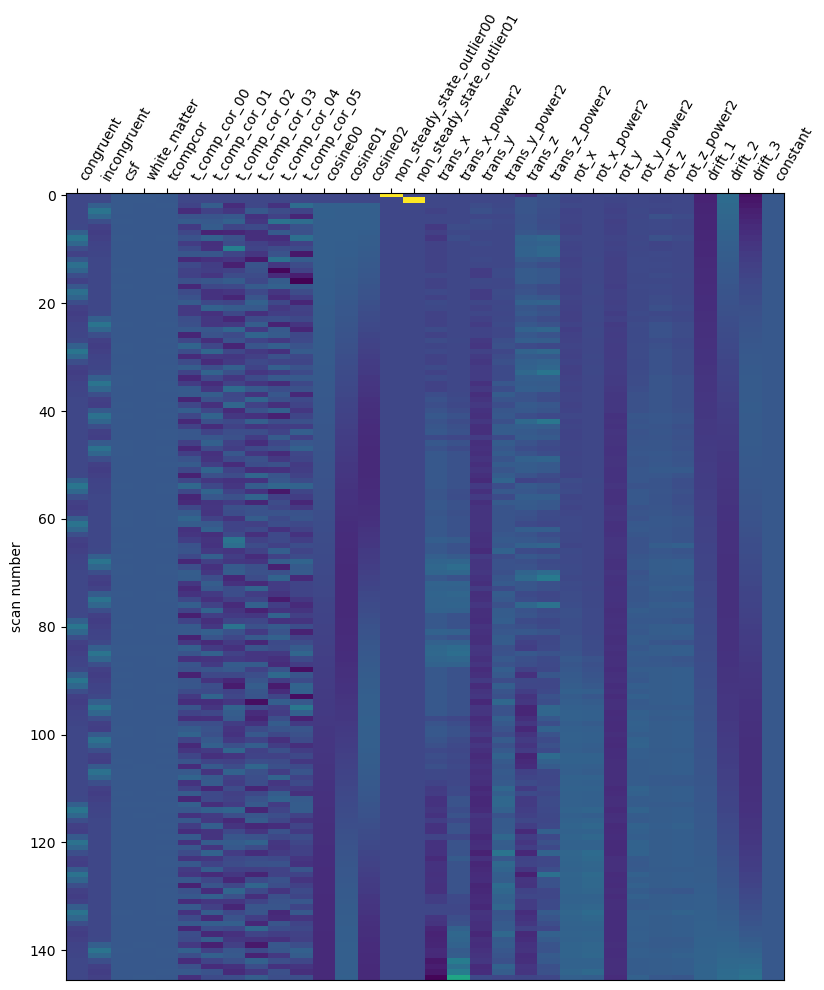

In [16]:
plot_design_matrix(X1)

## Fit the GLM


In [17]:

run = 1
epi_file = 'fmriprep/sub-07/func/sub-07_task-flanker_run-%d_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'%run
mask_file = 'fmriprep/sub-07/func/sub-07_task-flanker_run-%d_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'%run
fmri_glm = FirstLevelModel(t_r=tr,
                           mask_img=mask_file,
                           smoothing_fwhm=8)
fmri_glm = fmri_glm.fit(epi_file, design_matrices=X1)

In [18]:
contrast_matrix = np.eye(X1.shape[1])
contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(X1.columns)])
contrasts

{'congruent': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'incongruent': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'csf': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'white_matter': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tcompcor': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 't_comp_cor_00': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 't_comp_cor_01': array([0., 0., 0., 0., 0.,

In [19]:
zmap = fmri_glm.compute_contrast(contrasts['incongruent']-contrasts['congruent'])
zmap.shape

(65, 77, 49)

/home/per/anaconda3/envs/smiledev/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



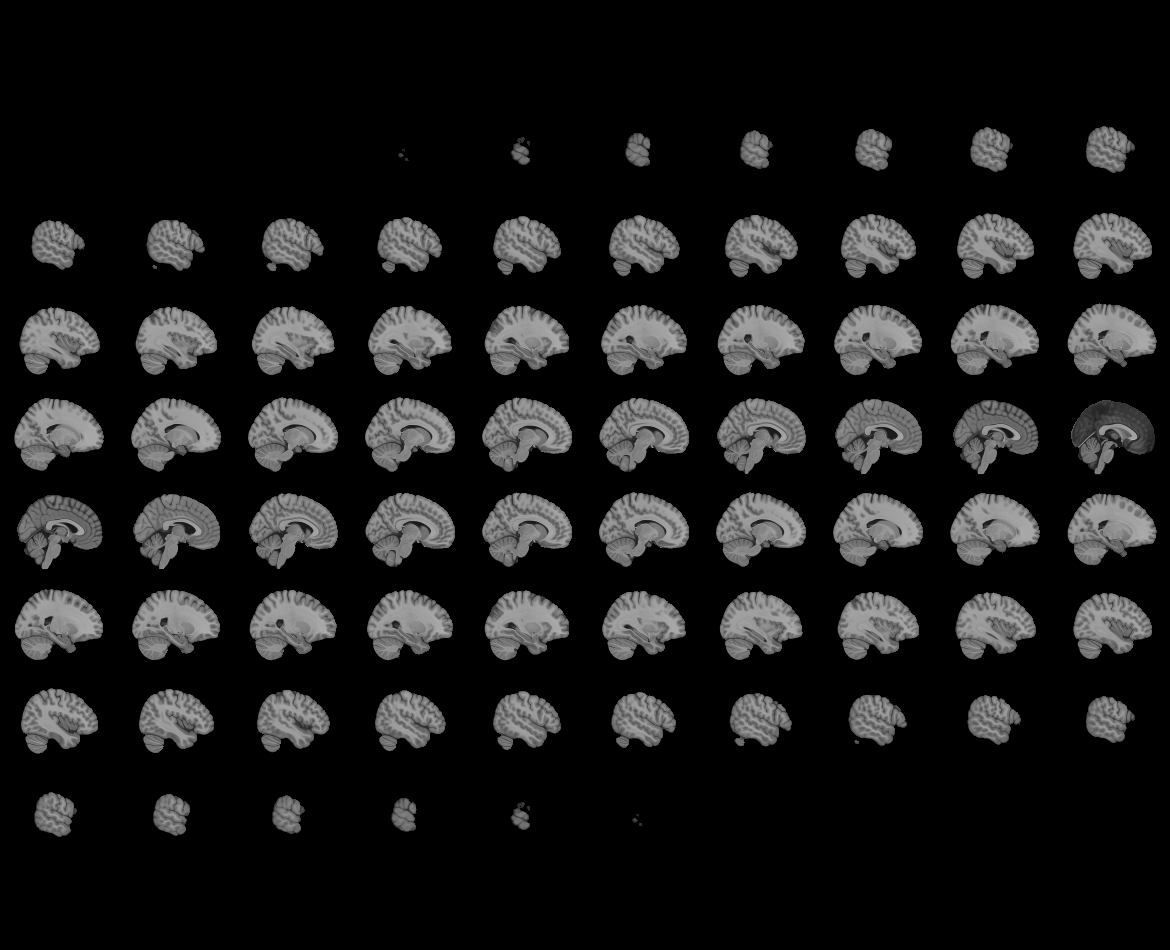
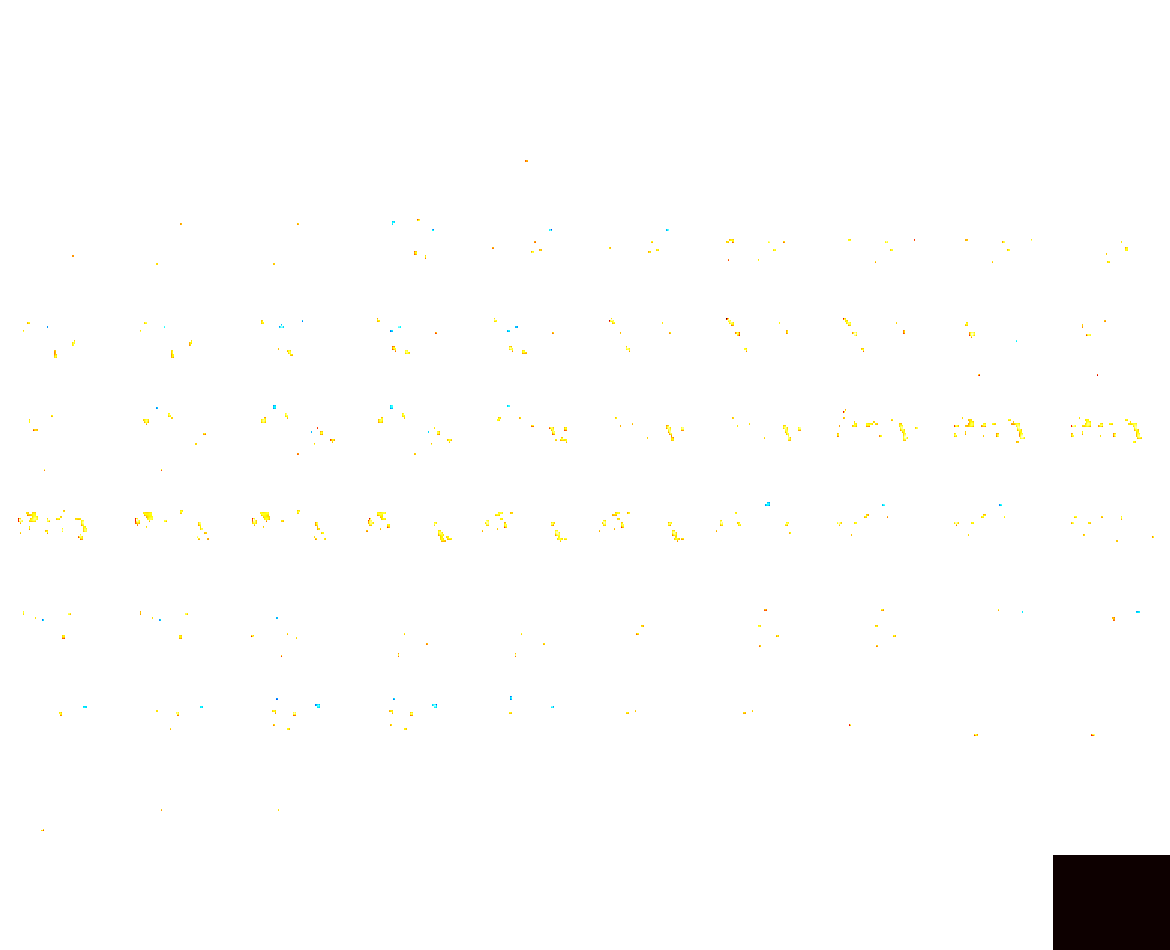

In [21]:
#del hfig 
hfig = plotting.view_img(zmap,threshold=3.0,
                  symmetric_cmap=True,)
hfig

## GLM Results
- We see some Anterior Cingulate Cortex activation, as well as in visual attention regions for the incongruent relative to congruent trials.

# MVPA Analysis

- MVPA turns the standard regression on its head!

- Instead of predicting neural activity at each voxel with the conditions of your experiment, it predicts thoughts/processes based on patterns of neural activity.


## Single-trial Betas (STB)

- To get started, we'll want to calculate the neural response for each trial, not just for the conditions.

In [22]:
# create a mean mask from the two run masks
from nilearn.image import mean_img
from nilearn.masking import compute_epi_mask
mean_mask = mean_img(['fmriprep/sub-07/func/sub-07_task-flanker_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
          'fmriprep/sub-07/func/sub-07_task-flanker_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'])
mean_mask = compute_epi_mask(mean_mask)


In [23]:
# run the model for each run to get single trial betas
z_maps = []
conditions_label = []
session_label = []
for run in [1, 2]:
    # pull the events
    events = pd.DataFrame({'trial_type': ['ev'+str(x).zfill(2) 
                                          for x in df[df['run']==run].index],
                           'onset': df[df['run']==run]['onset'],
                           'duration': df[df['run']==run]['duration']})
    
    # make the design matrix
    conf_file = 'fmriprep/sub-07/func/sub-07_task-flanker_run-%d_desc-confounds_timeseries.tsv' % run
    df_conf = pd.read_table(conf_file)
    df_conf = df_conf[df_conf.columns[df_conf.columns.isin(to_keep)]]
    df_conf = df_conf.dropna(axis=1)

    X1 = make_first_level_design_matrix(
        frame_times, events, drift_model='polynomial', drift_order=3,
        add_regs=df_conf.to_numpy(), 
        add_reg_names=list(df_conf.columns), hrf_model=hrf_model)

    # fit the first level model
    epi_file = 'fmriprep/sub-07/func/sub-07_task-flanker_run-%d_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'%run
    #mask_file = 'fmriprep/sub-07/func/sub-07_task-flanker_run-%d_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'%run
    fmri_glm = FirstLevelModel(t_r=tr,
                               mask_img=mean_mask,
                               smoothing_fwhm=4)
    fmri_glm = fmri_glm.fit(epi_file, design_matrices=X1)

    # extract the z maps for each event
    z_maps.extend([fmri_glm.compute_contrast(contrast_) 
                   for contrast_ in events.trial_type.unique()])
    
    # extend the conditions and sessions
    stims = list(df.loc[df['run']==run, 'Stimulus'])
    conditions_label.extend(stims)
    session_label.extend([run]*len(stims))

<Axes: label='conditions', ylabel='scan number'>

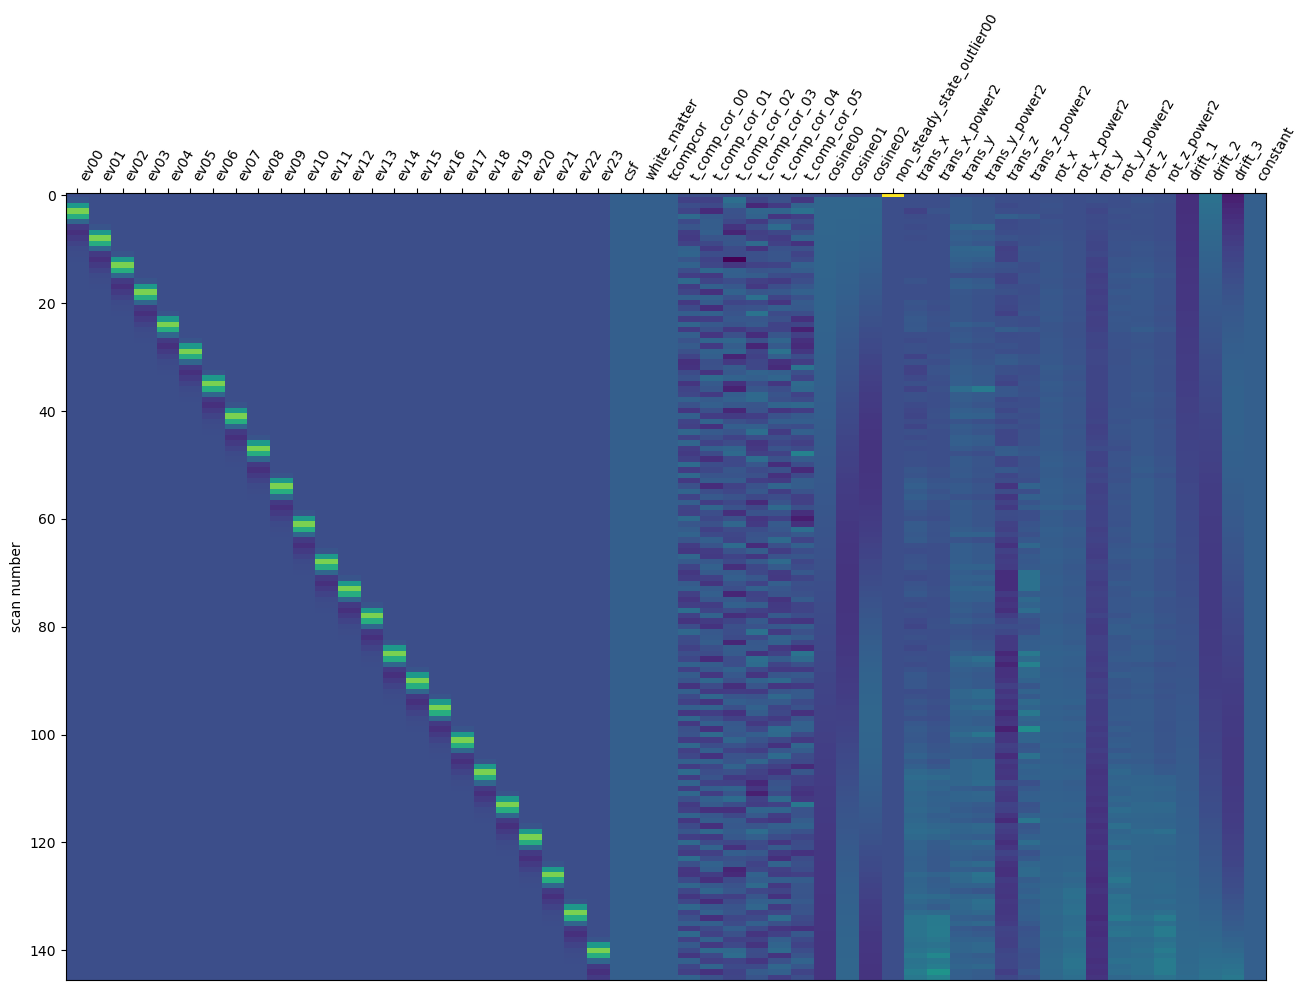

In [24]:
plot_design_matrix(X1)

## Build a decoder, then train and test it

In [28]:
from nilearn.decoding import Decoder
from sklearn.model_selection import LeaveOneGroupOut

In [69]:
# define and fit the decoder
decoder = Decoder(estimator='svc_l1', mask=mean_mask, 
                  standardize=False,
                  screening_percentile=10, 
                  cv=LeaveOneGroupOut(), 
                  scoring='accuracy')
decoder.fit(z_maps, conditions_label, groups=session_label)

# Return the corresponding mean prediction accuracy compared to chance
classification_accuracy = np.mean(list(decoder.cv_scores_.values()))
chance_level = 1. / len(np.unique(conditions_label))
print('Classification accuracy: {:.4f} / Chance level: {}'.format(
    classification_accuracy, chance_level))

/home/per/anaconda3/envs/smiledev/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification accuracy: 0.6667 / Chance level: 0.5


In [64]:
# use a binomial test to assess significance
stats.binomtest(31, n=48, p=0.5, alternative='greater')

BinomTestResult(k=31, n=48, alternative='greater', statistic=0.6458333333333334, pvalue=0.02973168762688517)

## What is it doing?

- Splitting the data into training and test sets based on the run.
- This is called Cross Validation (CV)

### Trianing
- For each training set, it will train the model to decode congruent vs. incongruent with the whole brain activity.
- There are far to many voxels (i.e., features) relative to the number of events (observations), so we have to use fancy tricks:
  - One is to penalize the weights so that the model finds *sparse* solutions
  - Another is to toss voxels that do not have much variance between conditions

### Testing
- After training on one half of the data, the model attempts to predict on the other half of the data that it hasn't seen.
- It saves out the accuracy of how well it was able to make these predictions, which we then report.

## Plotting the weights used to predict condition

/home/per/anaconda3/envs/smiledev/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



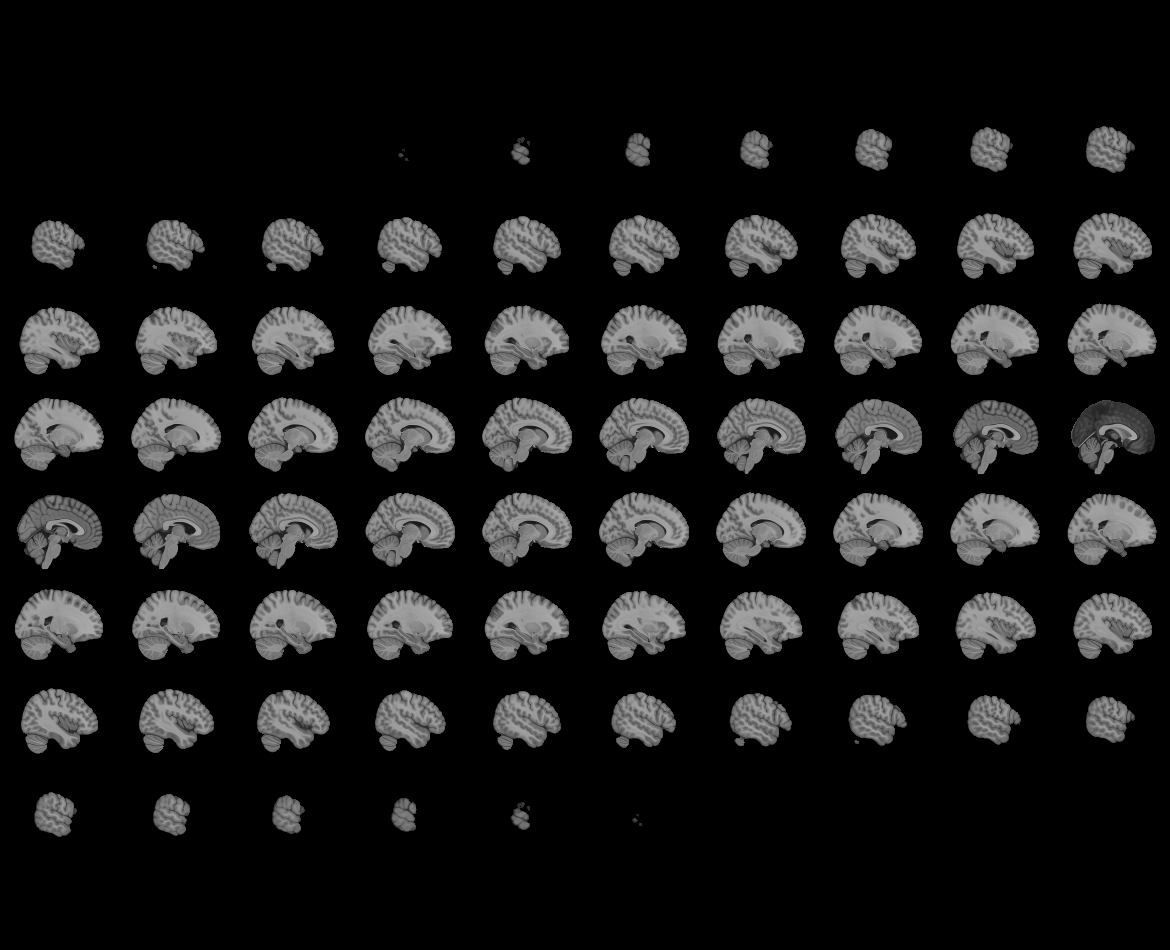
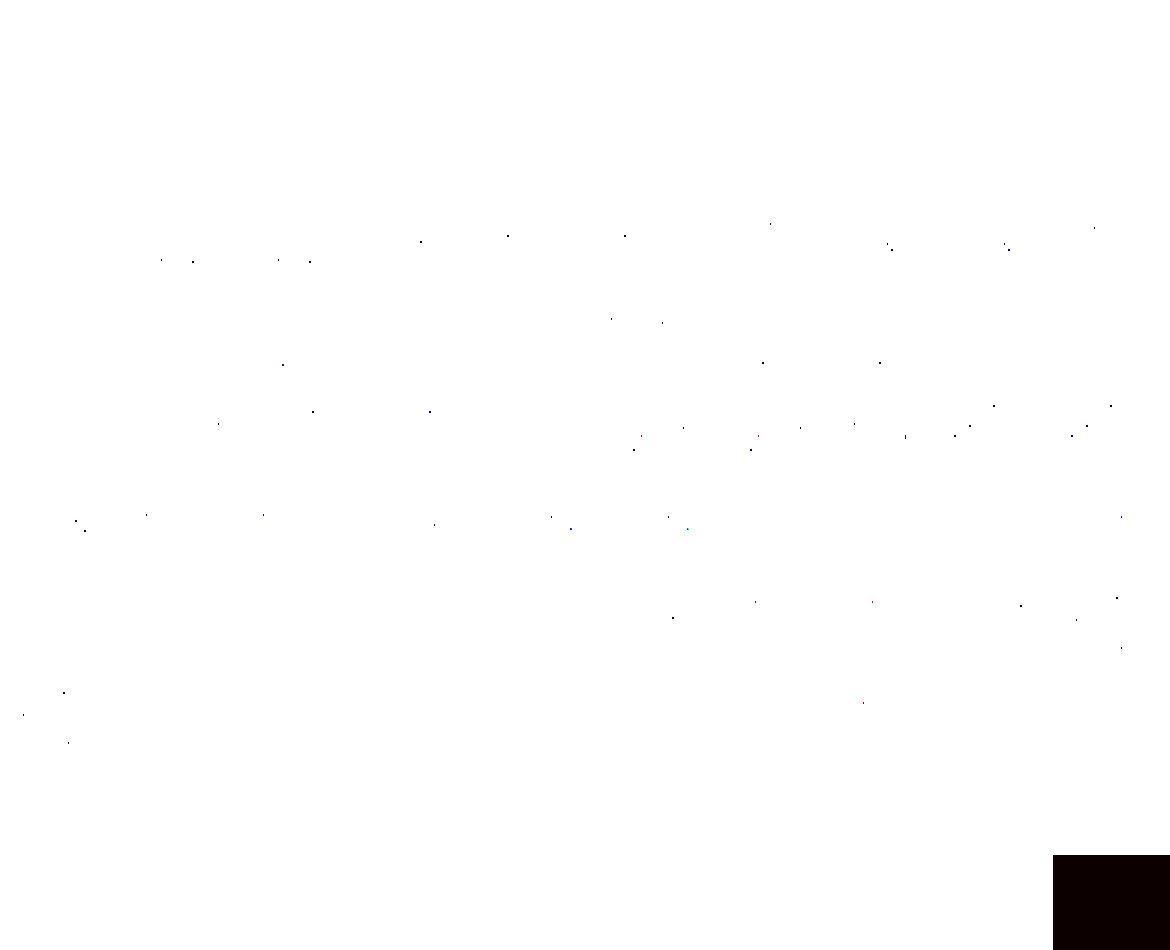

In [58]:
#del hfig
hfig = plotting.view_img(decoder.coef_img_['incongruent'],
                  symmetric_cmap=True,)
hfig

## MVPA Summary

- We just scratched the surface of MVPA methods!
- Nonetheless, it looks like we can decode from patterns of neural activity whether a participant is currently processing an incongruent or congruent stimulus.
- The brain maps are too sparse to be interpretable.

# Functional Connectivity
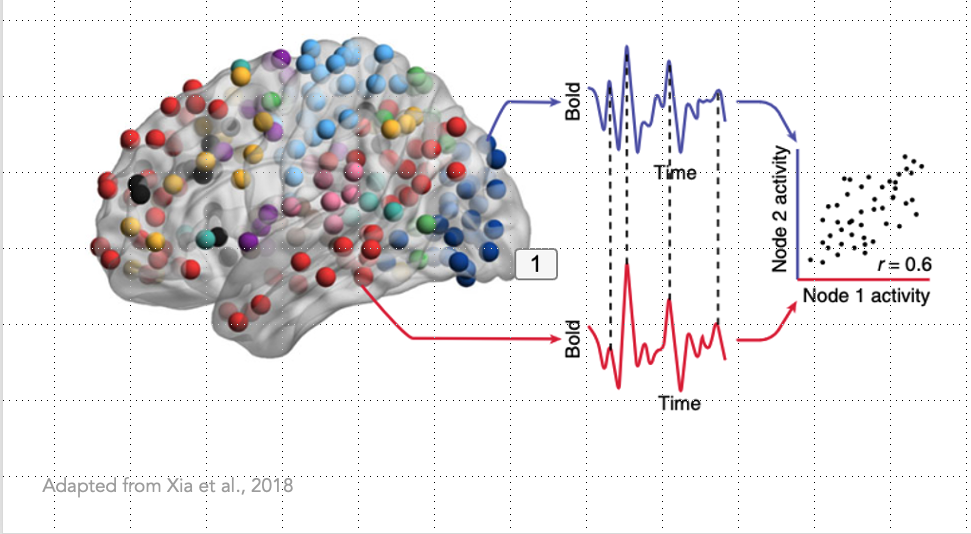
- Brain regions do not work in isolation!
- Another popular approach is to evaluate how regions coordinate their activity in support of cognitive processing

## Reducing dimensionality

- Correlating the activity of every pair of voxels would be both computationally and memory intensive.
- We can use a pre-defined atlas to reduce dimensionality.

In [103]:
from nilearn import datasets

# load the Harvard Oxford atlas
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm',
                                             symmetric_split=True)
atlas_filename = atlas.maps
labels = atlas.labels

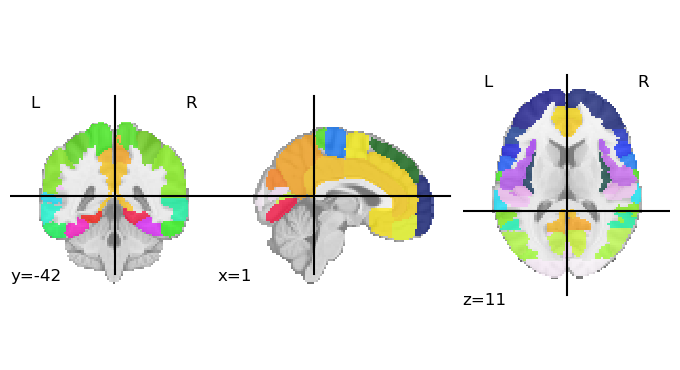

In [85]:
# plot the regions
plotting.plot_roi(atlas_filename)

## Extracting the mean timeseries

- Now we need to extract the average time series for each region in the atlas.

In [99]:
from nilearn.maskers import NiftiLabelsMasker

masker = NiftiLabelsMasker(
    labels_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
)

# we'll just do this for one run (this is run 1 or 2)
run = 1

# load in the confounds
conf_file = 'fmriprep/sub-07/func/sub-07_task-flanker_run-%d_desc-confounds_timeseries.tsv' % run
df_conf = pd.read_table(conf_file)
df_conf = df_conf[df_conf.columns[df_conf.columns.isin(to_keep)]]
df_conf = df_conf.dropna(axis=1)

# define the functional data
epi_file = 'fmriprep/sub-07/func/sub-07_task-flanker_run-%d_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'%run

# calculate the average time_series for each region
time_series = masker.fit_transform(epi_file,
                                   confounds=df_conf)

[NiftiLabelsMasker.wrapped] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('fmriprep/sub-07/func/sub-07_task-flanker_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x7f4c3ffbfa30>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': 'zscore_sample',
  'standardize_confounds': 'zscore_sample',
  'strategy': 'mean',
  't_r': None,
  'target_aff

In [100]:
# check the shape (timepoints by regions)
time_series.shape

(146, 96)

## Calculating pairwise correlations

- Now we need to calculate the correlations between time_series for each pair of regions

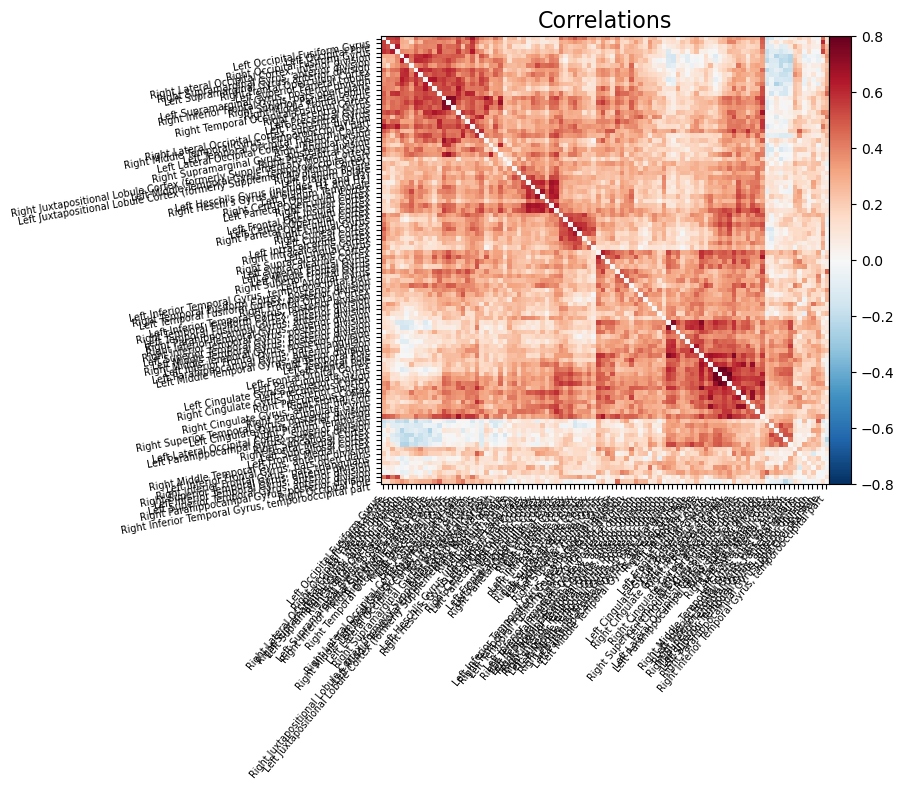

In [115]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Plot the correlation matrix
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)

# The labels we have start with the background (0), 
# hence we skip the first label
# matrices are ordered for block-like representation
plotting.plot_matrix(
    correlation_matrix,
    figure=(10, 8),
    labels=labels[1:],
    vmax=0.8,
    vmin=-0.8,
    title="Correlations",
    reorder=True,
)

## Plotting pairwise correlations on the brain

- The matrix plot is a bit too dense to track.
- We can instead plot this as a undirected graph connecting brain regions

In [106]:
# extract the coordinates of the atlas regions
coords = plotting.find_parcellation_cut_coords(
    labels_img=atlas_filename)


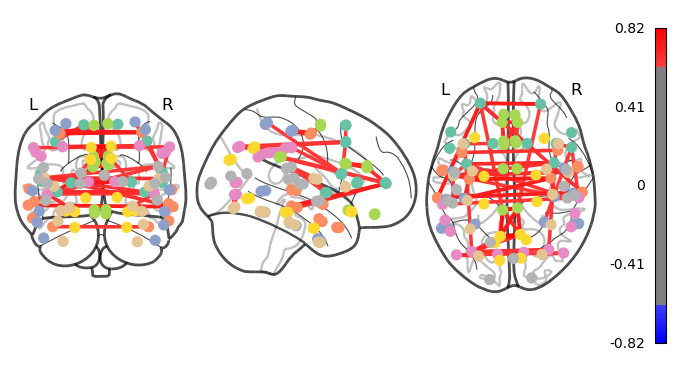

In [126]:

# We threshold to keep only the 1% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(
    correlation_matrix, coords, 
    edge_threshold="99%", colorbar=True
)

plotting.show()

## Connectivity Conclusions

- We're just scratching the surface of functional connectivity!
- Becky has been working on novel ways to extract functional regions of interest.
- Fun additional approaches entail connectome predictive modeling and connectome fingerprinting. 

# Assignment due after Thanksgiving

- We'll post an MRI analysis assignment that will be due the week after Thanksgiving.
- We will still hold office hours, at least on Monday, to answer any questions.
- Have a great weekend and break!